# EDA and Data Preprocessing

In [446]:
# import of libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, mannwhitneyu
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,

    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)


# Reproducibility setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Visual adjustments
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [447]:
# Dataset load
df_raw = pd.read_csv('synthetic_ecommerce_data.csv')
df = df_raw.copy()

In [448]:
# Size review and first registrations
print("Shape del dataset:", df.shape)
df.head()

Shape del dataset: (100000, 15)


Transaction_ID     Customer_ID   Product_ID  \
0  8b460852-7c64-46fa-998b-b0976879d082     Customer_65  Product_224   
1  418612e7-8744-4ba3-bb0c-105b47e2a968   Customer_1910  Product_584   
2  5bc3b98f-cb0c-4b12-947c-df8bbb35a73e   Customer_2306  Product_374   
3  28fb67c8-e8c0-447a-841c-f760730de0eb  Customer_17206  Product_220   
4  8bee087a-a8a9-45bb-89d7-04d1710f1b00  Customer_16033  Product_358   

  Transaction_Date  Units_Sold  Discount_Applied  Revenue  Clicks  \
0       2024-10-06         134              0.14   305.54      11   
1       2024-10-29         109              0.30  1102.19      15   
2       2024-04-04         116              0.04   471.29      16   
3       2024-08-25         125              0.20   980.26      12   
4       2024-05-05         132              0.07   803.76      44   

   Impressions  Conversion_Rate         Category         Region  Ad_CTR  \
0           65             0.17      Electronics         Europe  0.0180   
1          201             0.07  Home Appliances           Asia  0.1589   
2          199             0.08             Toys           Asia  0.0596   
3          355             0.03         Clothing         Europe  0.0444   
4          355             0.12            Books  North America  0.1270   

   Ad_CPC  Ad_Spend  
0    0.55      9.90  
1    0.40     63.56  
2    1.50     89.40  
3    0.44     19.54  
4    0.53     67.31

In [449]:
print("\nDataset information:")
df.info()

print("\nNull values per column:")
print(df.isnull().sum())

print("\nNumber of duplicates rows:", df.duplicated().sum())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_Spend          100000 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage

### First Data Cleaning

In [450]:
# Remove ID columns or unique identifiers (if any), as they do not provide predictive value.
df.drop(columns=['Transaction_ID','Customer_ID','Product_ID'], inplace=True)

# Elimination of duplicates (there aren't any but I do it as if there were)
df.drop_duplicates(inplace=True)

# Null elimination (there is no null either but I run it as if there is)
df.dropna(inplace=True)

In [451]:
# Type division (we will do the typing later)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = ['Category','Region'] # this takes away our IDs

## Univariate analysis


Statistical description (numerical):
                     count        mean         std    min       25%       50%  \
Units_Sold        100000.0  128.328580   49.679873  51.00   84.0000  127.0000   
Discount_Applied  100000.0    0.149871    0.086692   0.00    0.0700    0.1500   
Revenue           100000.0  553.110811  428.366294   7.65  221.2600  428.1550   
Clicks            100000.0   24.539170   14.412477   0.00   12.0000   25.0000   
Impressions       100000.0  254.539060  141.466606  10.00  132.0000  254.0000   
Conversion_Rate   100000.0    0.198138    0.361187   0.00    0.0500    0.1000   
Ad_CTR            100000.0    0.104988    0.054806   0.01    0.0575    0.1052   
Ad_CPC            100000.0    1.051250    0.549252   0.10    0.5800    1.0500   
Ad_Spend          100000.0  110.477240   87.015846   1.05   38.6100   87.2400   

                       75%      max  
Units_Sold        166.0000   716.00  
Discount_Applied    0.2200     0.30  
Revenue           805.8650  5704.18  

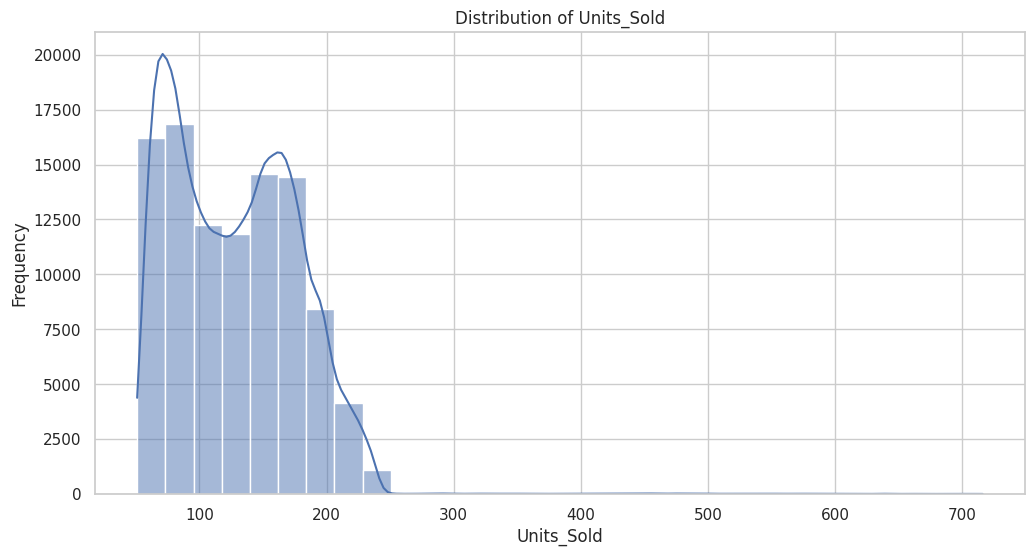

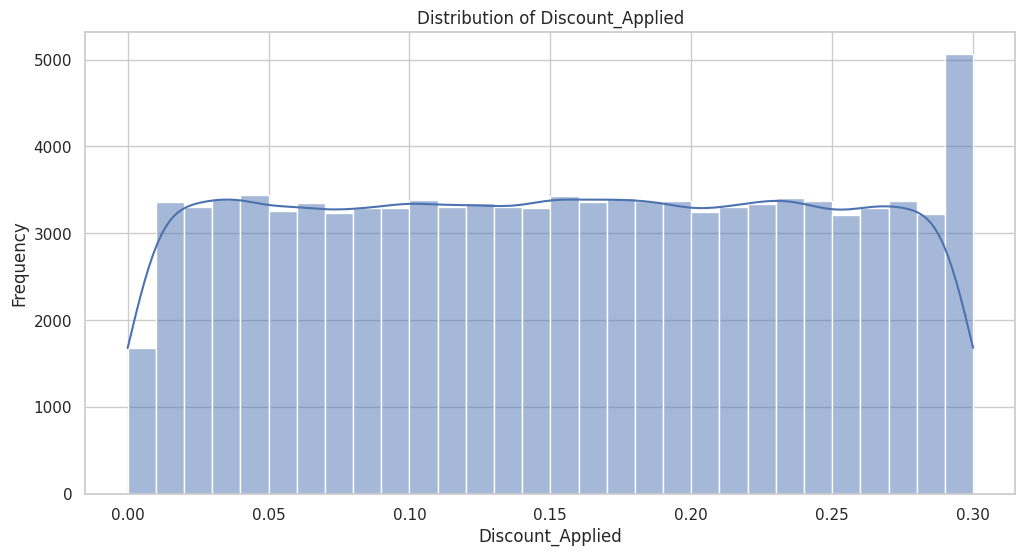

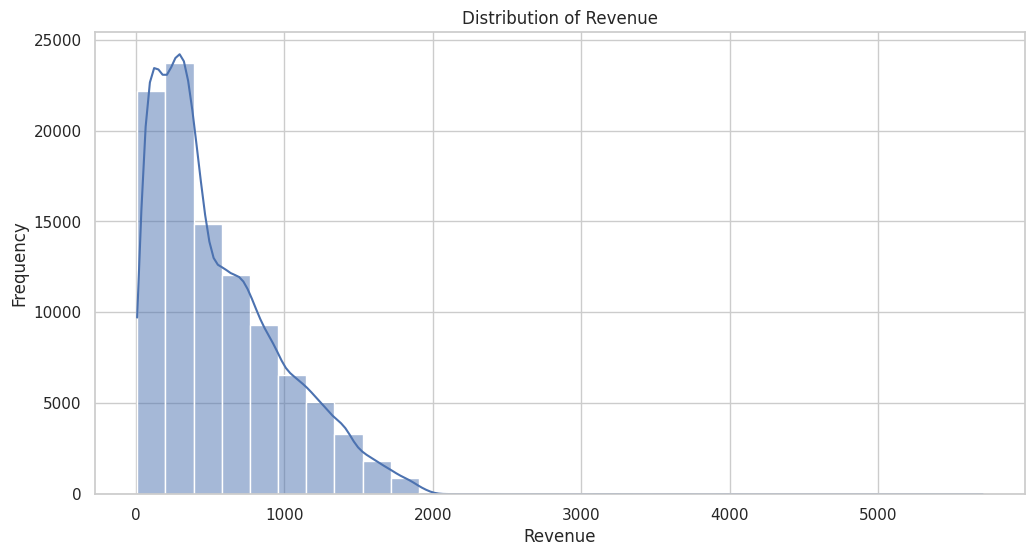

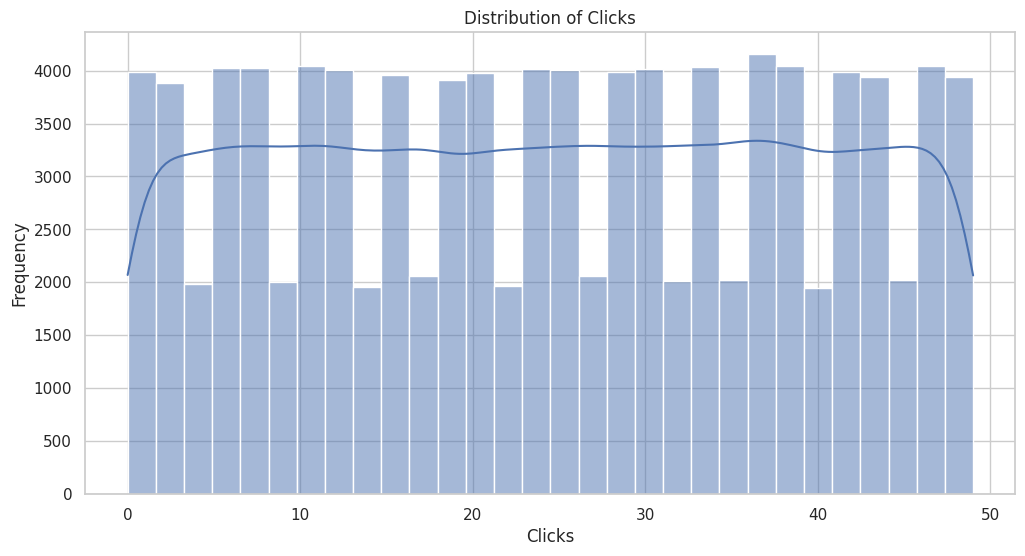

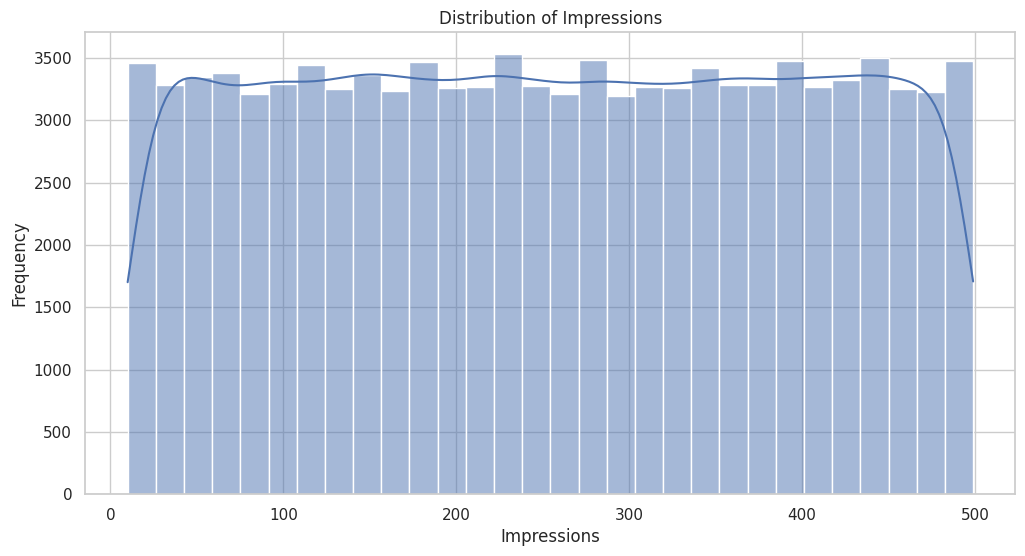

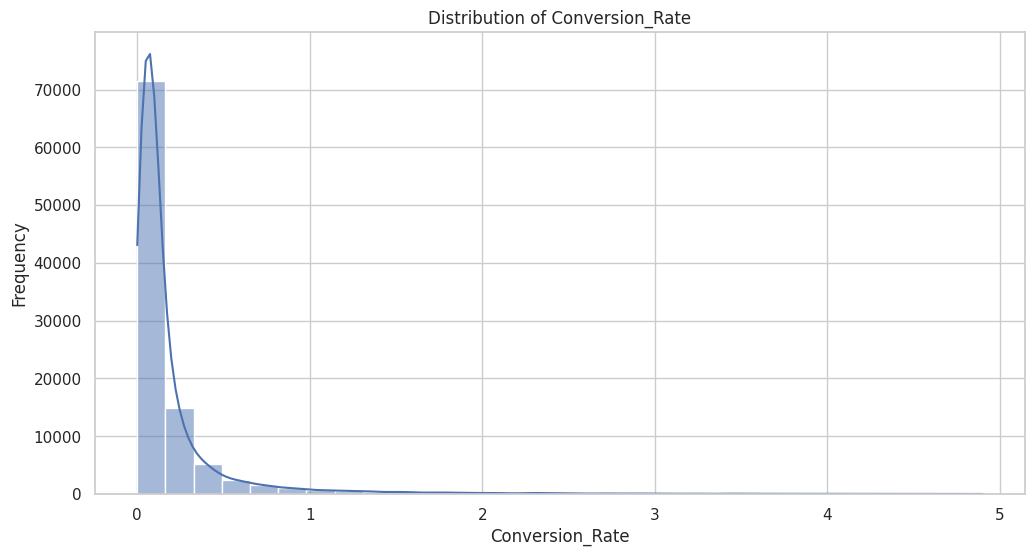

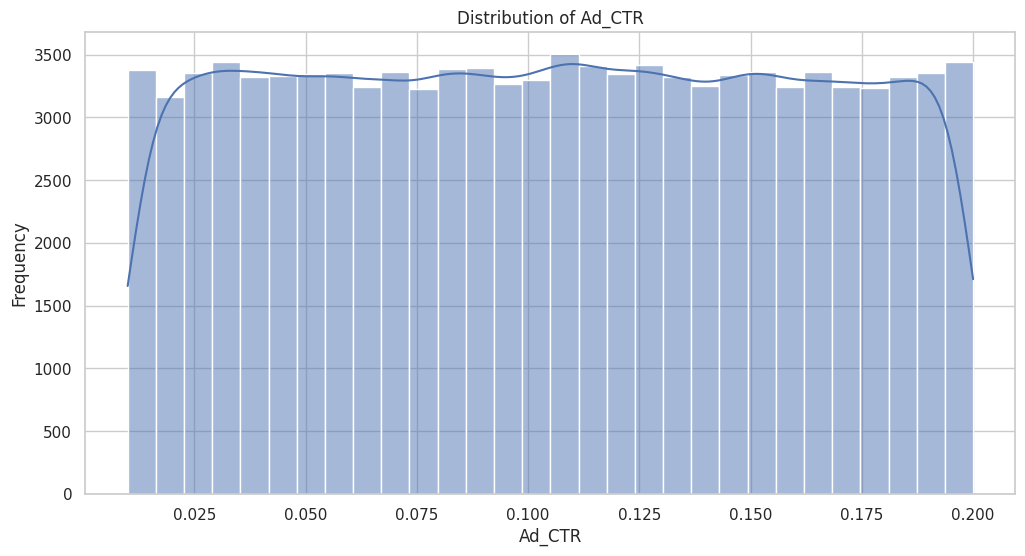

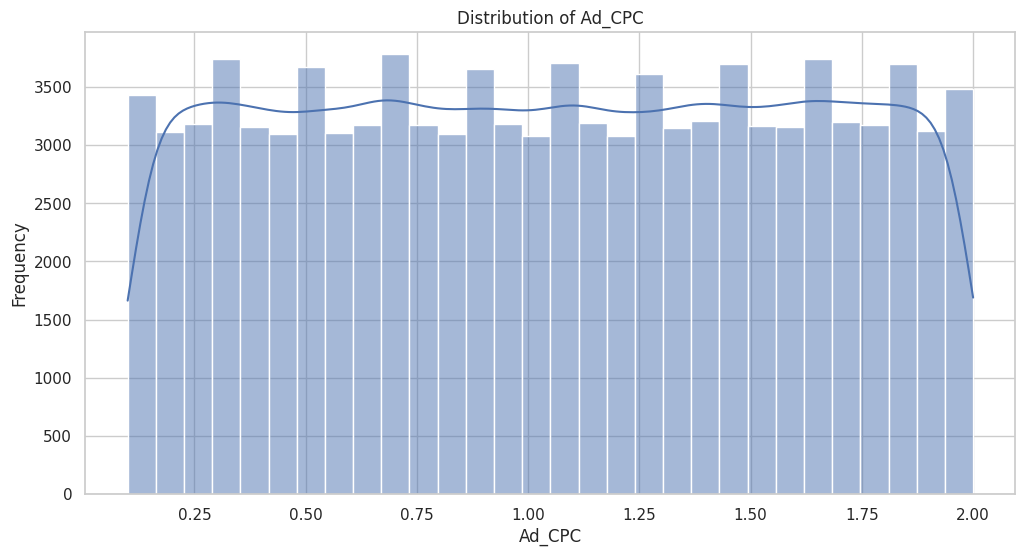

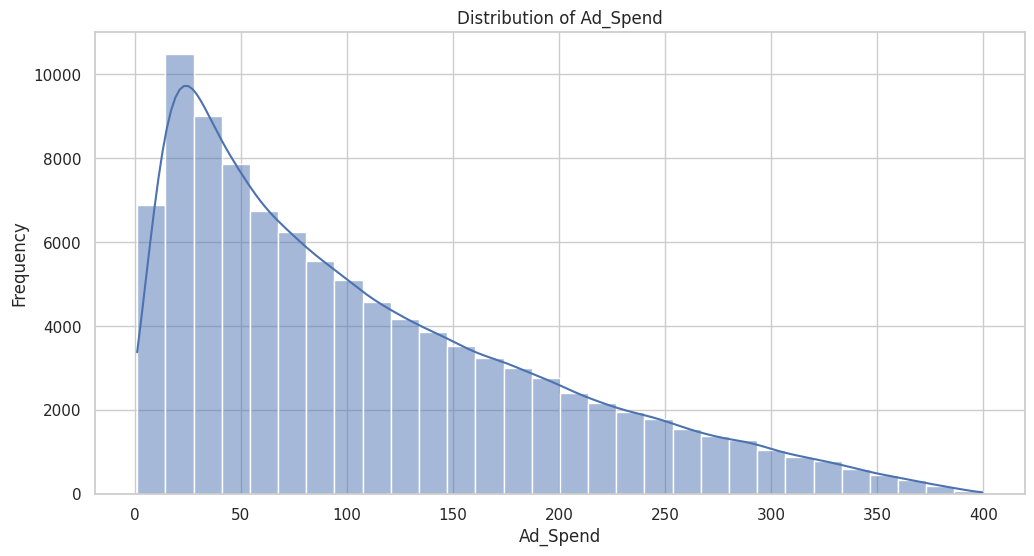

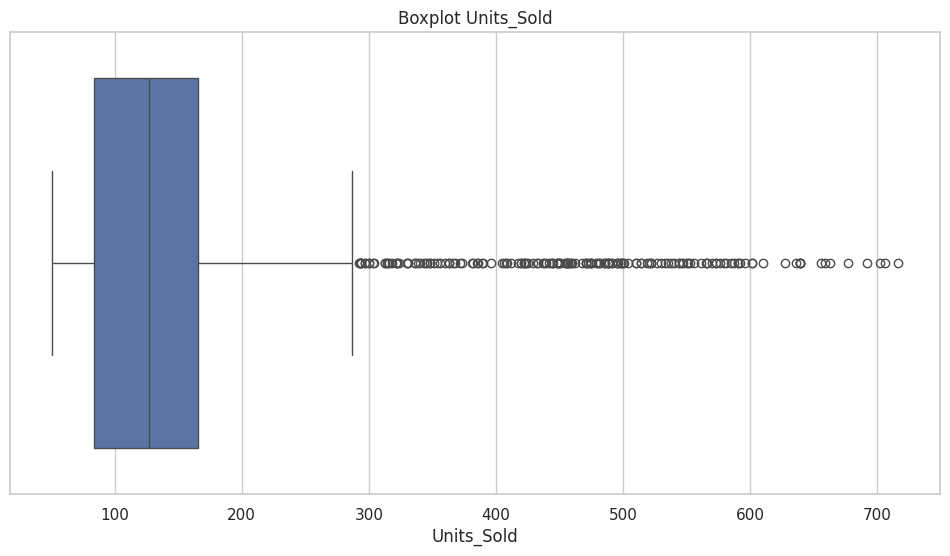

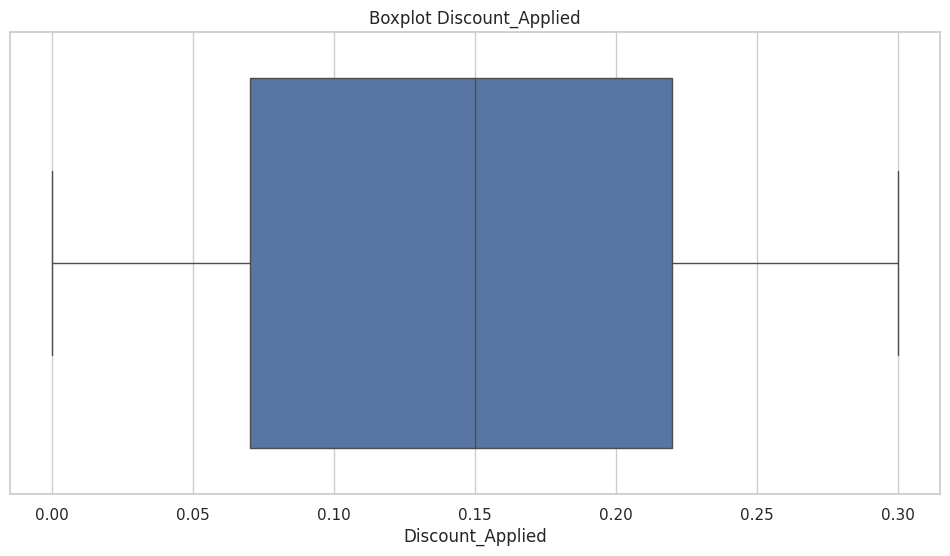

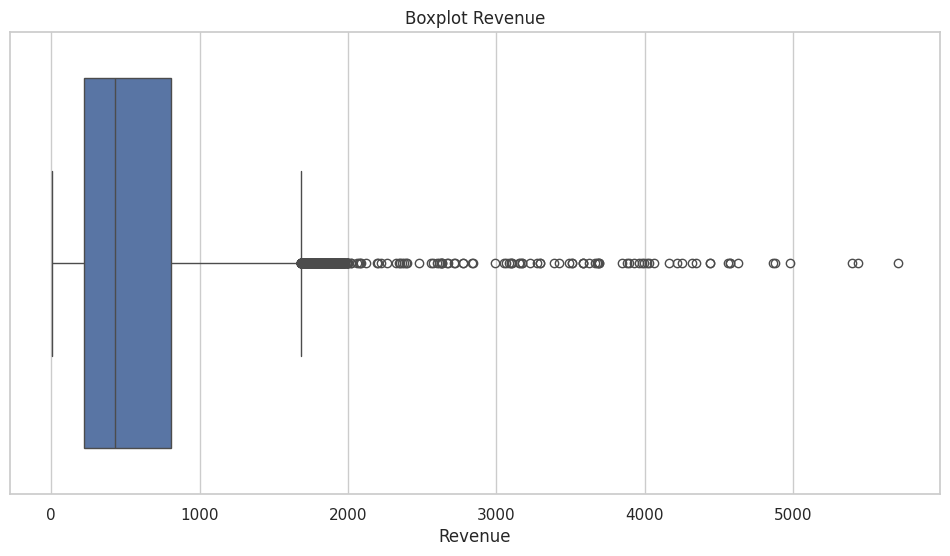

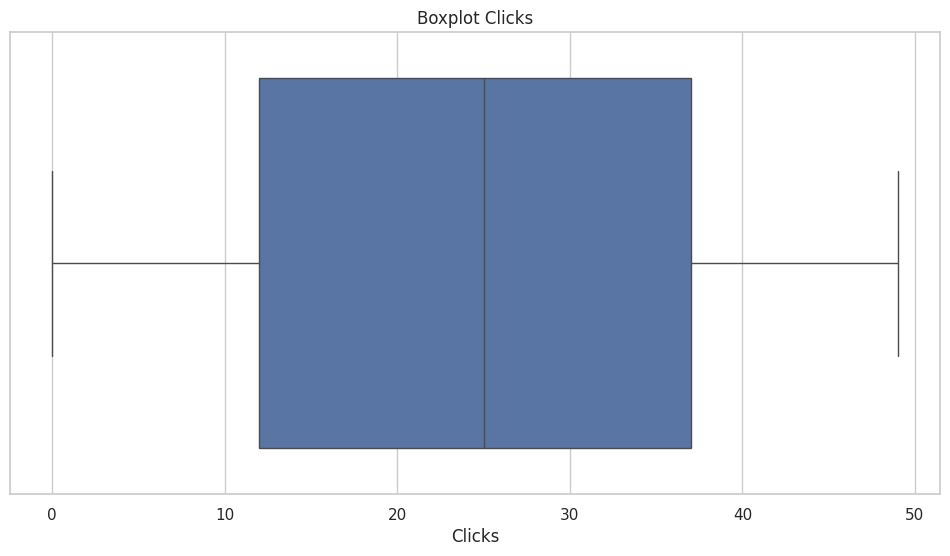

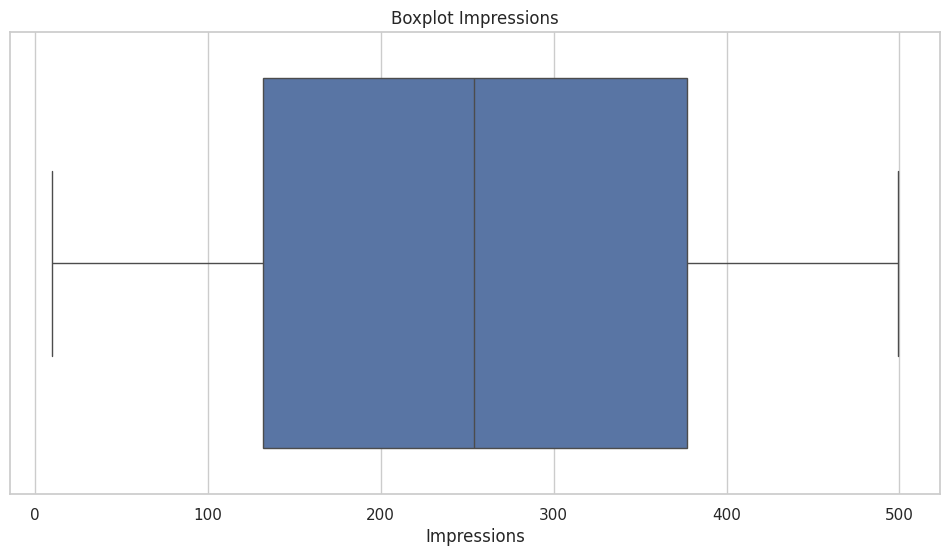

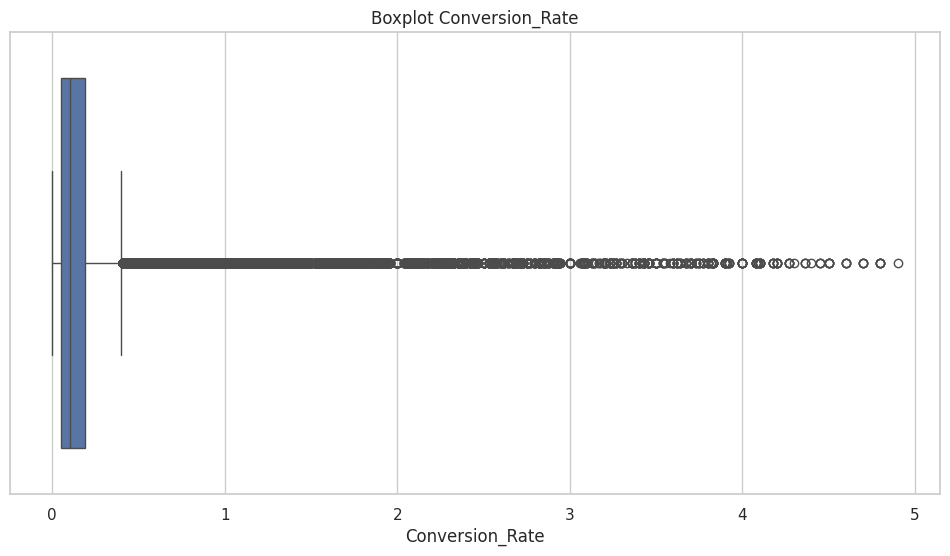

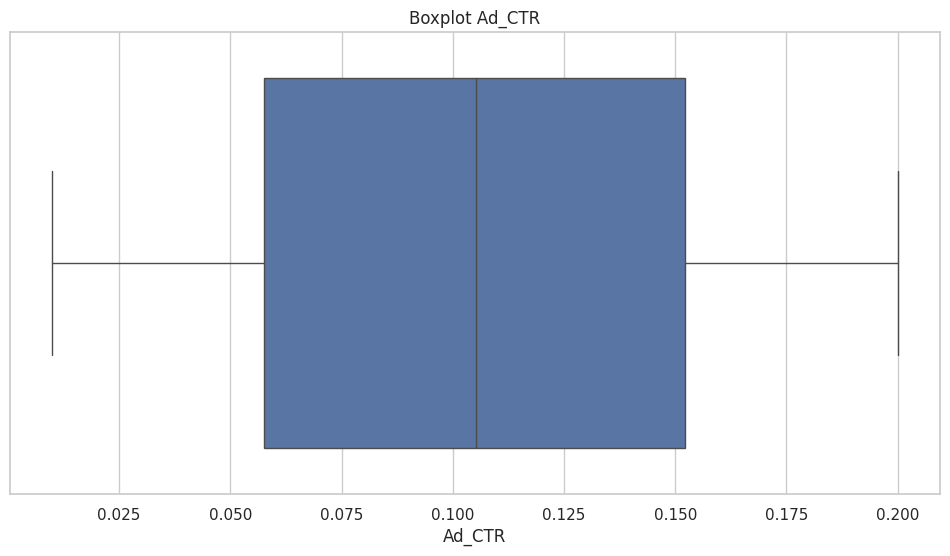

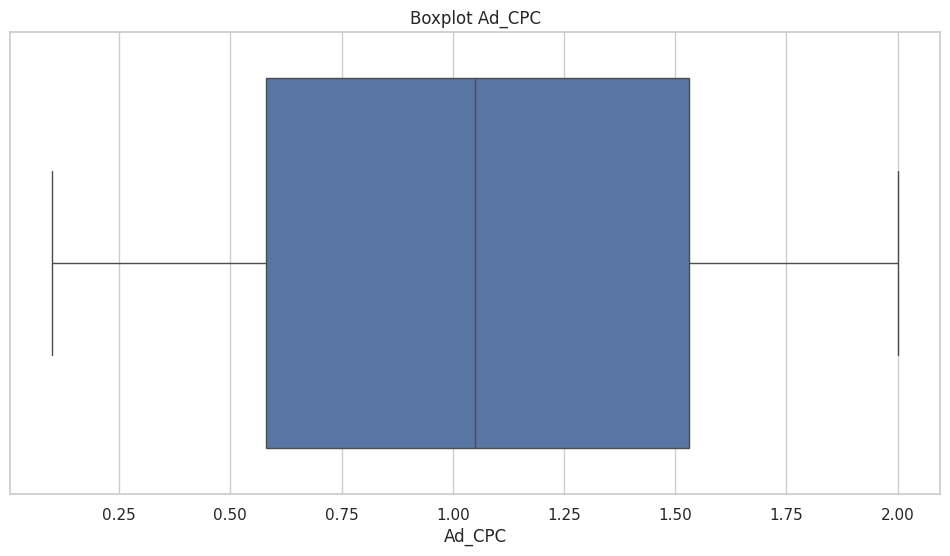

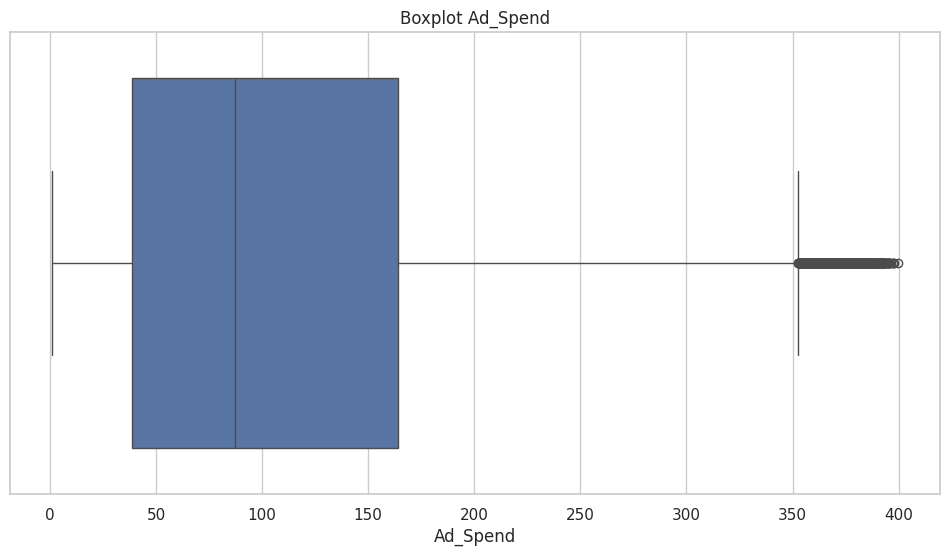

In [452]:
print("\nStatistical description (numerical):")
print(df[num_cols].describe().T)

# Skewness and kurtosis
print("\nSkewness and Kurtosis:")
skew_kurt = pd.DataFrame({'skew': df[num_cols].skew(), 'kurtosis': df[num_cols].kurt()})
print(skew_kurt)

# Histograms + KDE
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Outliers Boxplots
for col in num_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

### Feature Creation

In [453]:
# Cap Revenue and calculate log_ROAS
cap = df["Revenue"].quantile(0.99)
df["Revenue_capped"] = df["Revenue"].clip(upper=cap)
df["ROAS"]     = df["Revenue_capped"] / (df["Ad_Spend"] + 1e-6)
df["log_ROAS"] = np.log1p(df["ROAS"])

# Create margin per unit and tag High_Margin
df["Revenue_per_Unit"] = df["Revenue_capped"] / (df["Units_Sold"] + 1e-6)
cut_margin = df["Revenue_per_Unit"].quantile(0.90)   # top‑10 %
df["High_Margin"] = (df["Revenue_per_Unit"] >= cut_margin)

# Apply log only to columns with skew > 1 and positive values
df["log_Ad_Spend"] = np.log1p(df["Ad_Spend"])
df["log_Conversion_Rate"] = np.log1p(df["Conversion_Rate"])

# Create date derived variables. We are going to create only the useful ones
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')
df['Transaction_Quarter'] = df['Transaction_Date'].dt.quarter
df['Is_Weekend'] = df['Transaction_Date'].dt.weekday >= 5
df["Weekend_Discount"] = df["Discount_Applied"] * df["Is_Weekend"].astype("int8")
df["CTR_log_Clicks"]  = df["Ad_CTR"] * np.log1p(df["Clicks"])
df['Click_Efficiency'] = df['Clicks'] / (df['Ad_Spend'] + 1e-6)


In [454]:
print("Proporción High_Margin:", df["High_Margin"].mean())


Proporción High_Margin: 0.1


In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Transaction_Date     100000 non-null  datetime64[ns]
 1   Units_Sold           100000 non-null  int64         
 2   Discount_Applied     100000 non-null  float64       
 3   Revenue              100000 non-null  float64       
 4   Clicks               100000 non-null  int64         
 5   Impressions          100000 non-null  int64         
 6   Conversion_Rate      100000 non-null  float64       
 7   Category             100000 non-null  object        
 8   Region               100000 non-null  object        
 9   Ad_CTR               100000 non-null  float64       
 10  Ad_CPC               100000 non-null  float64       
 11  Ad_Spend             100000 non-null  float64       
 12  Revenue_capped       100000 non-null  float64       
 13  ROAS           

### Data elimination

In [456]:
# Eliminate all the features converted
df.drop(['Revenue_capped','Transaction_Date','ROAS', 'Revenue_per_Unit', 'Conversion_Rate','Revenue','Ad_Spend'], axis=1, inplace=True)

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Units_Sold           100000 non-null  int64  
 1   Discount_Applied     100000 non-null  float64
 2   Clicks               100000 non-null  int64  
 3   Impressions          100000 non-null  int64  
 4   Category             100000 non-null  object 
 5   Region               100000 non-null  object 
 6   Ad_CTR               100000 non-null  float64
 7   Ad_CPC               100000 non-null  float64
 8   log_ROAS             100000 non-null  float64
 9   High_Margin          100000 non-null  bool   
 10  log_Ad_Spend         100000 non-null  float64
 11  log_Conversion_Rate  100000 non-null  float64
 12  Transaction_Quarter  100000 non-null  int32  
 13  Is_Weekend           100000 non-null  bool   
 14  Weekend_Discount     100000 non-null  float64
 15  CTR_log_Clicks    

### Variable Typing

In [458]:
# Change integer types if values allow
df["Units_Sold"] = df["Units_Sold"].astype(np.int16)
df["Clicks"] = df["Clicks"].astype(np.int16)
df["Impressions"] = df["Impressions"].astype(np.int32)

# Float64 to float32
float_cols = ["Discount_Applied", "Ad_CTR", "Ad_CPC",
              "log_ROAS", "log_Ad_Spend", "log_Conversion_Rate",
              "CTR_log_Clicks", "Weekend_Discount", "Click_Efficiency",]

df[float_cols] = df[float_cols].astype(np.float32)

# Categoricals
df["Category"] = df["Category"].astype("category")
df["Region"] = df["Region"].astype("category")
df['Transaction_Quarter'] = df['Transaction_Quarter'].astype("category")
df["Is_Weekend"] = df["Is_Weekend"].astype("category")

# High_Margin ya está en int32, pero podría hacerlo uint8 al ser binaria
df["High_Margin"] = df["High_Margin"].astype(np.uint8)

In [459]:
num_cols = [
    "Units_Sold",
    "Discount_Applied",
    "Clicks",
    "Impressions",
    "Ad_CTR",
    "Ad_CPC",
    "log_Ad_Spend",
    "log_Conversion_Rate",
    "CTR_log_Clicks",
    "Weekend_Discount",
    "Click_Efficiency",
]

cat_cols = [
    'Category',
    'Region',
    'Transaction_Quarter',
    'Is_Weekend'
]

target_reg = "log_ROAS"            # REGRESIÓN
target_clf = "High_Margin"         # CLASIFICACIÓN

I leave the elimination of highly correlated variables at this point, which I will do after the rest of the analysis.

### Treatment of Outliers

In [460]:
# Outlier elimination using the IQR method

# I am not going to use Z-Score because this is useful when our distribution is normal.
# In this case we should use the IQR (Interquartile Range) method, which is more robust.
outlier_mask = pd.Series(False, index=df.index)

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    col_outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    outlier_mask |= col_outliers  # Acumulamos filas con outliers

print(f"Rows with outliers {outlier_mask.sum()} shall be removed.")
df = df[~outlier_mask].reset_index(drop=True)

Rows with outliers 36131 shall be removed.


In [461]:
# Visual update of the Outliers

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    print(f"{col}: {outliers.sum()} outliers (IQR)")

Units_Sold: 0 outliers (IQR)
Discount_Applied: 0 outliers (IQR)
Clicks: 0 outliers (IQR)
Impressions: 0 outliers (IQR)
Ad_CTR: 0 outliers (IQR)
Ad_CPC: 0 outliers (IQR)
log_Ad_Spend: 232 outliers (IQR)
log_Conversion_Rate: 3227 outliers (IQR)
CTR_log_Clicks: 0 outliers (IQR)
Weekend_Discount: 5273 outliers (IQR)
Click_Efficiency: 4030 outliers (IQR)


## Bivariate analysis

### For regression

#### Correlation Matrix

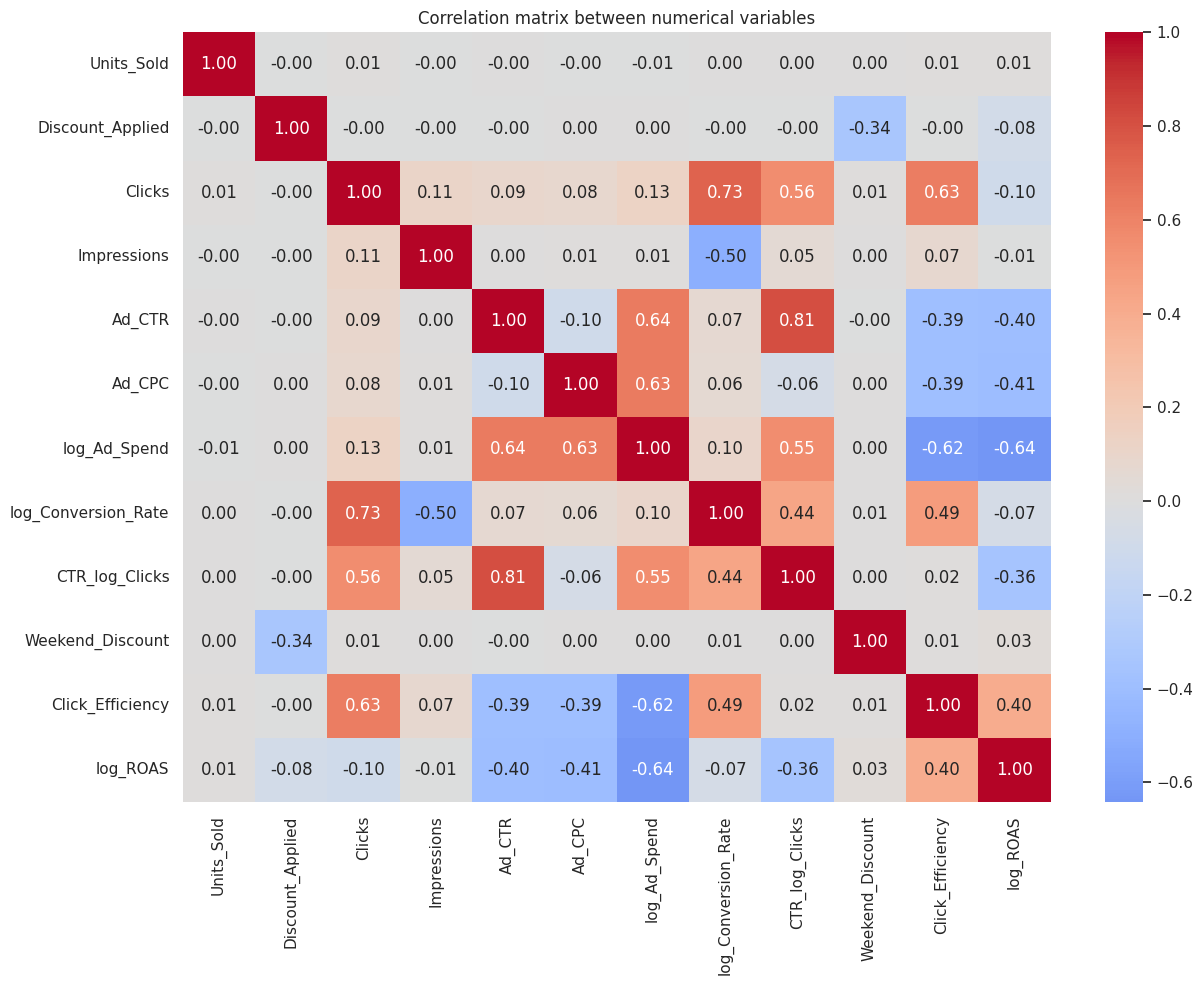

In [463]:
# Numerical correlation (Spearman)
corr_matrix = df[num_cols + ['log_ROAS']].corr(method='spearman')
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Correlation matrix between numerical variables')
plt.show()

This means that the important variables according to spearman are (note that this does not mean that the rest are not important):
* Clicks
* log_Conversion_Rate
* log_Ad_Spend
* Ad_CPC
* Click_Efficiency

Those five stand out as the ones that exhibit the strongest monotonic relationships ( |ρ| ≥ ≈0.60) with at least one other variable in the Spearman matrix, while the rest of the features hover very close to zero.

The rest aren’t “unimportant”; they just don’t show strong rank-order ties with any companion variable under this particular metric, so they neither raise collinearity alarms nor dominate the correlation structure.

#### ANOVA Test

In [464]:
for col in cat_cols:
    groups = [df[df[col] == level]['log_ROAS'] for level in df[col].unique()]
    stat, p = f_oneway(*groups)
    print(f"{col}: p = {p:.4f}")

Category: p = 0.0000
Region: p = 0.2056
Transaction_Quarter: p = 0.4899
Is_Weekend: p = 0.0000


This ANOVA test has been used to see if the log_ROAS means are different according to categorical values. We can take "Category" as predictor variable.

#### Variables vs log_Revenue

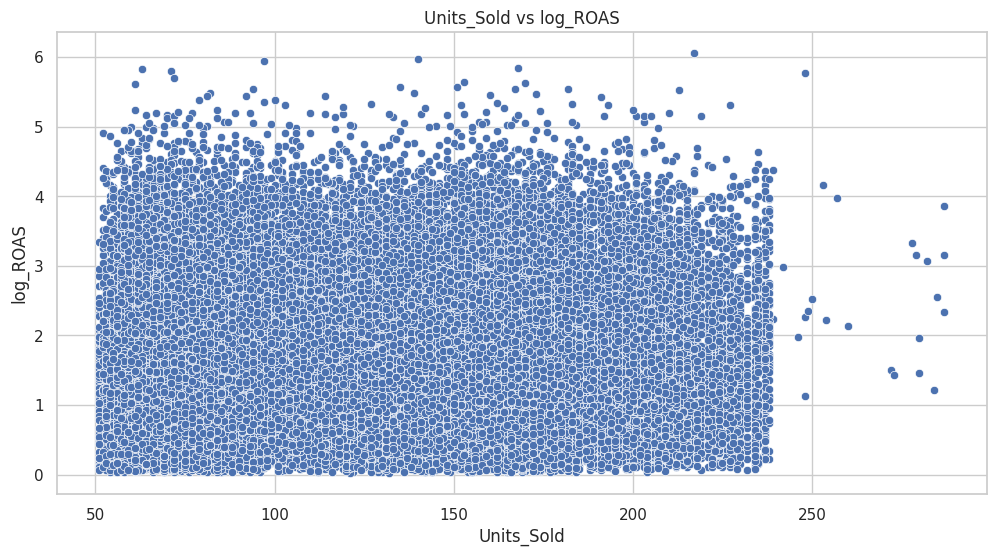

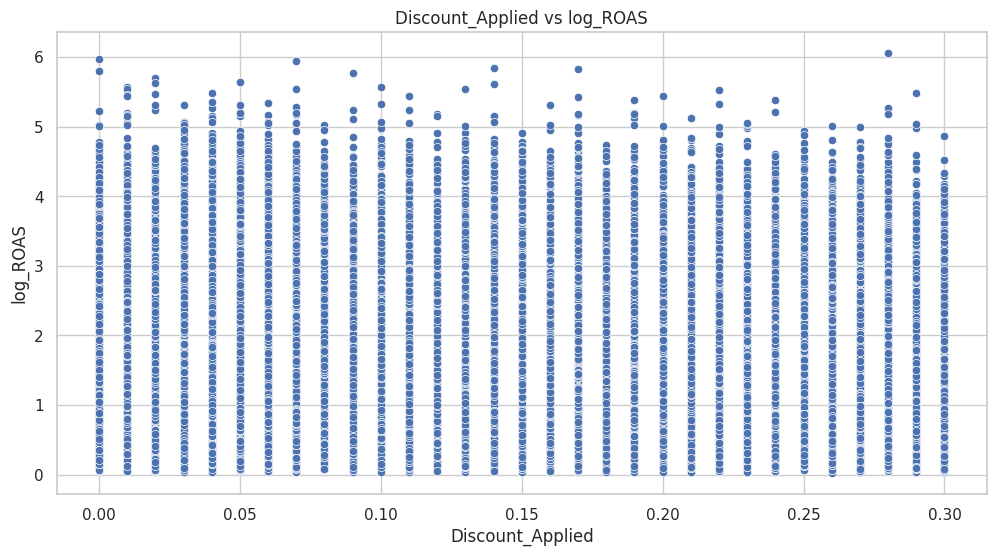

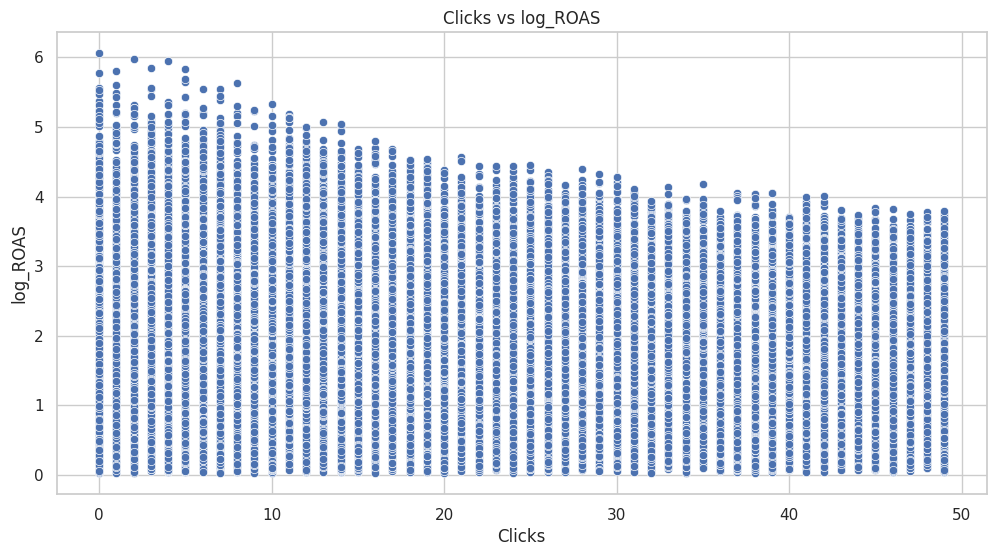

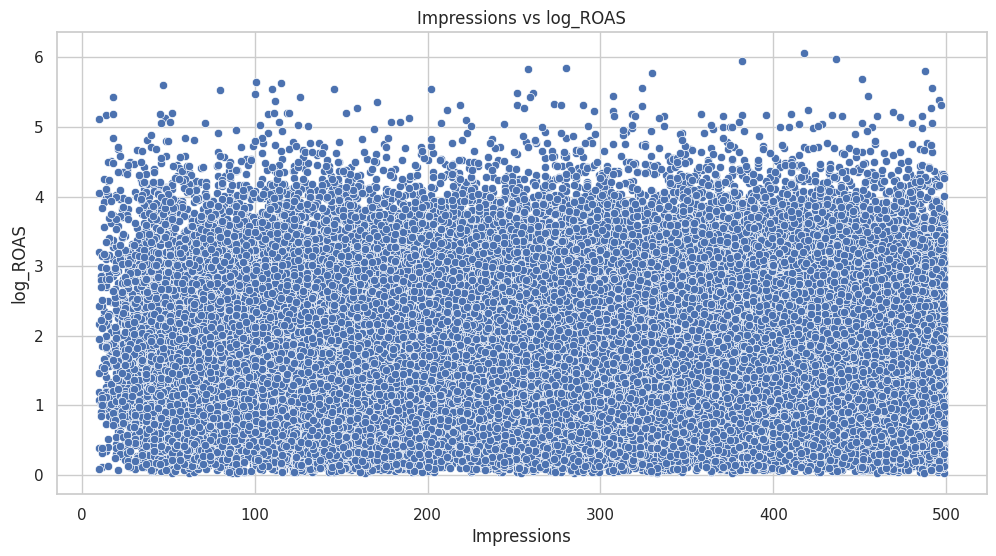

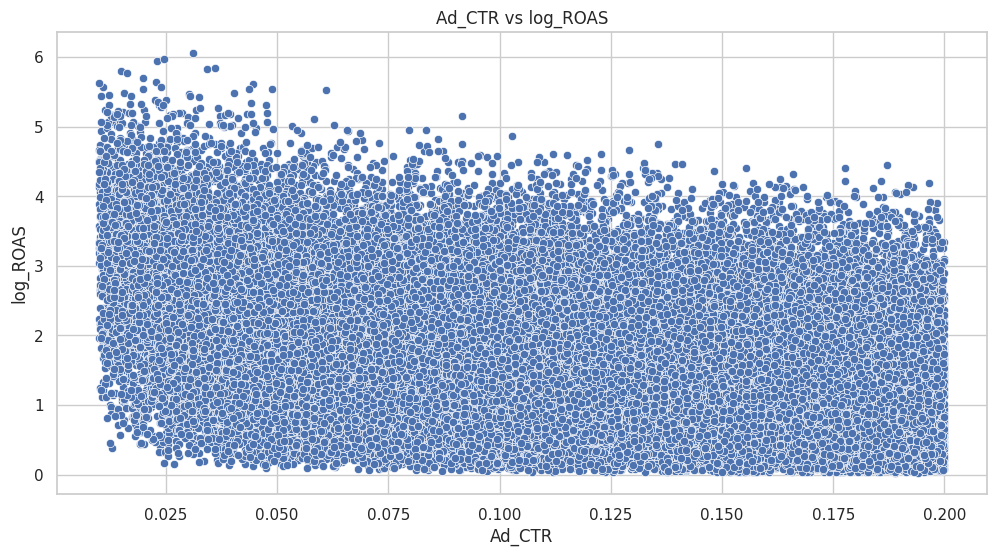

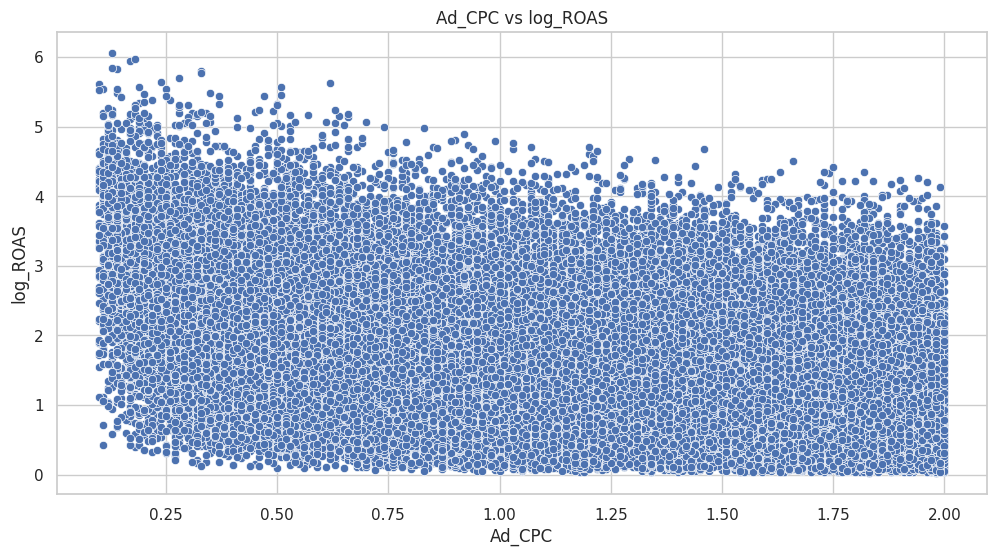

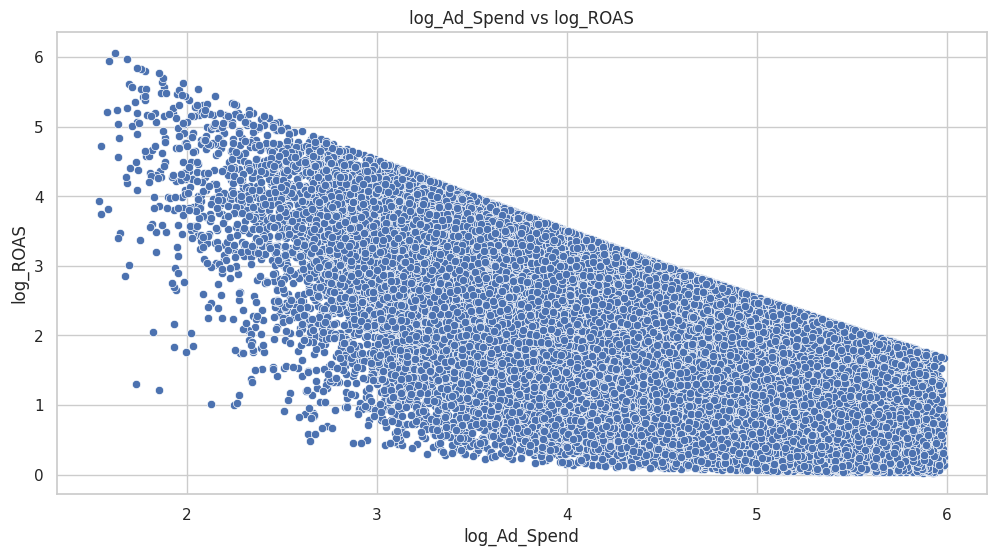

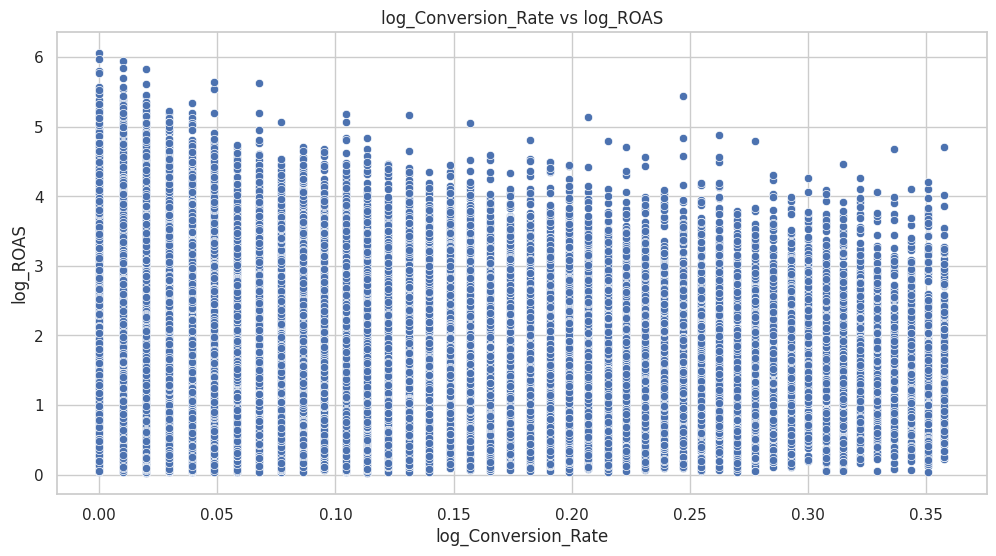

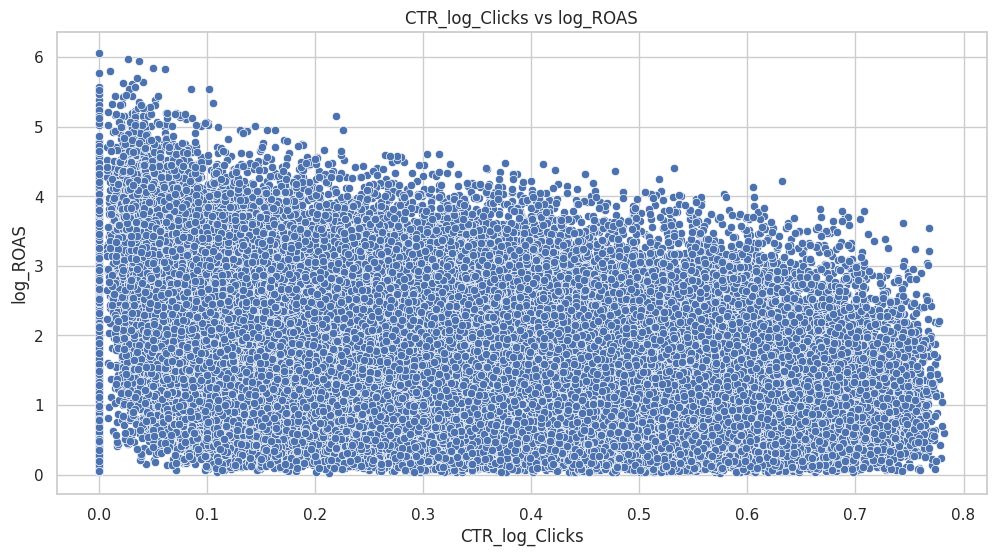

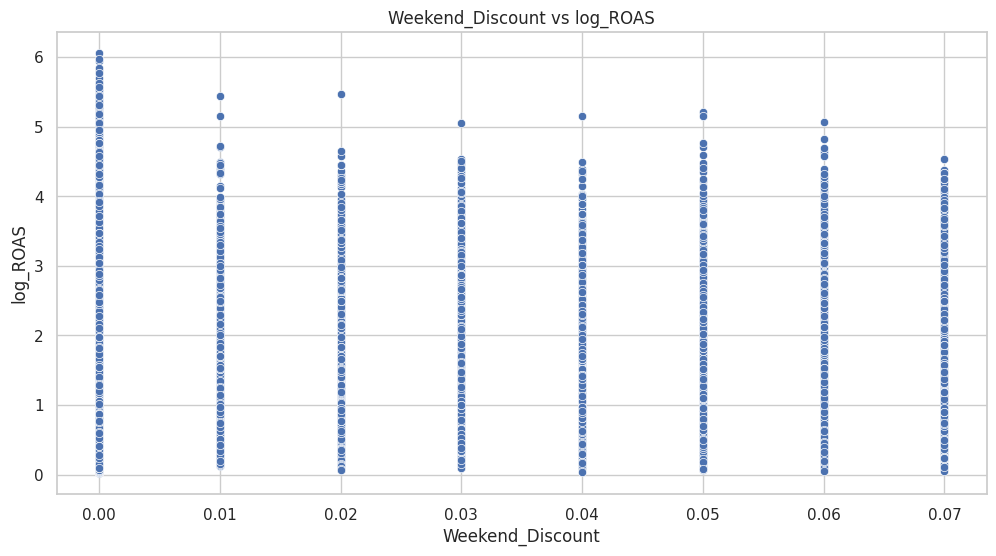

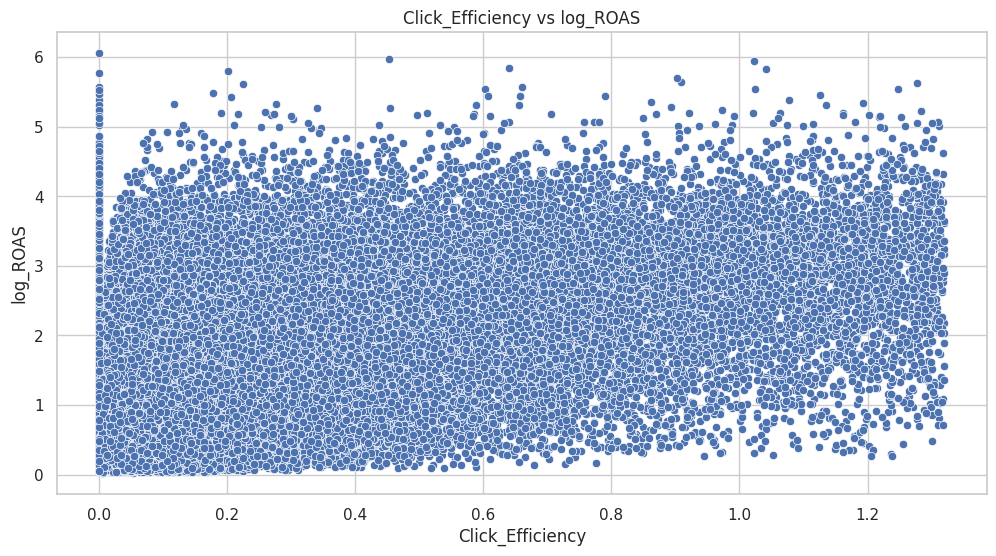

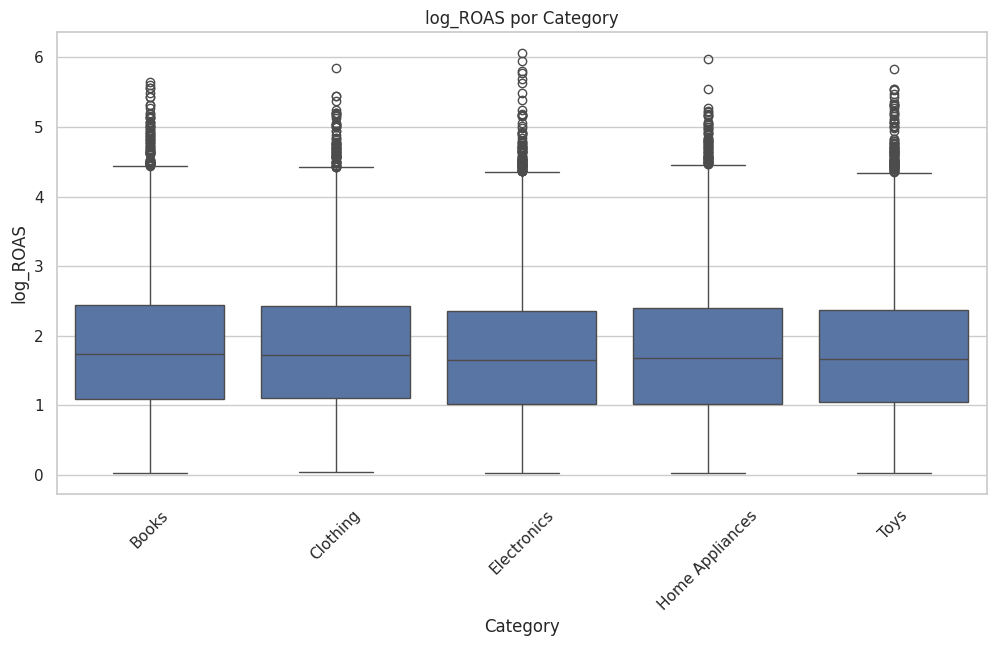

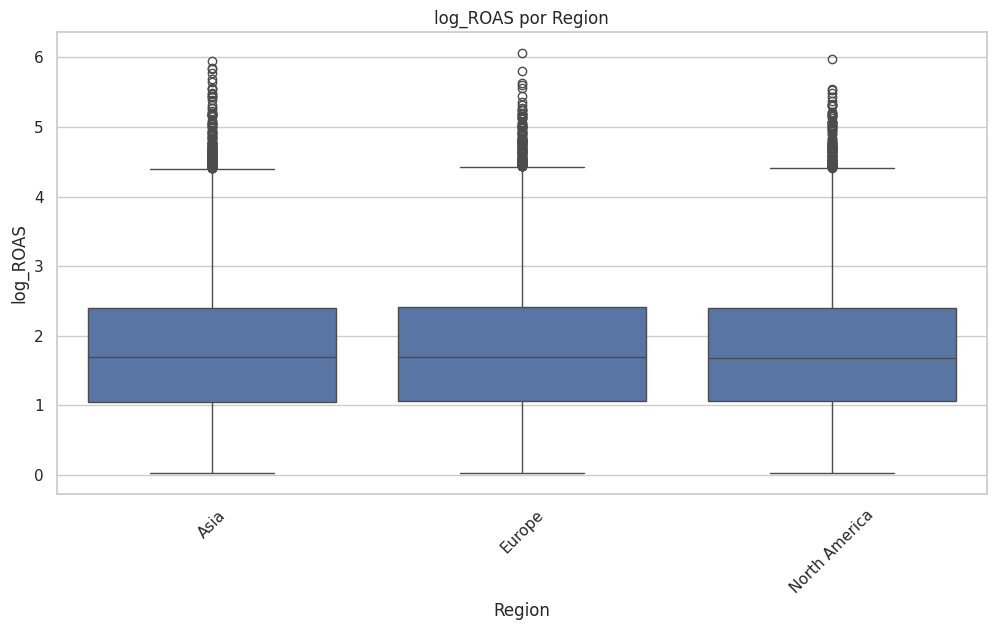

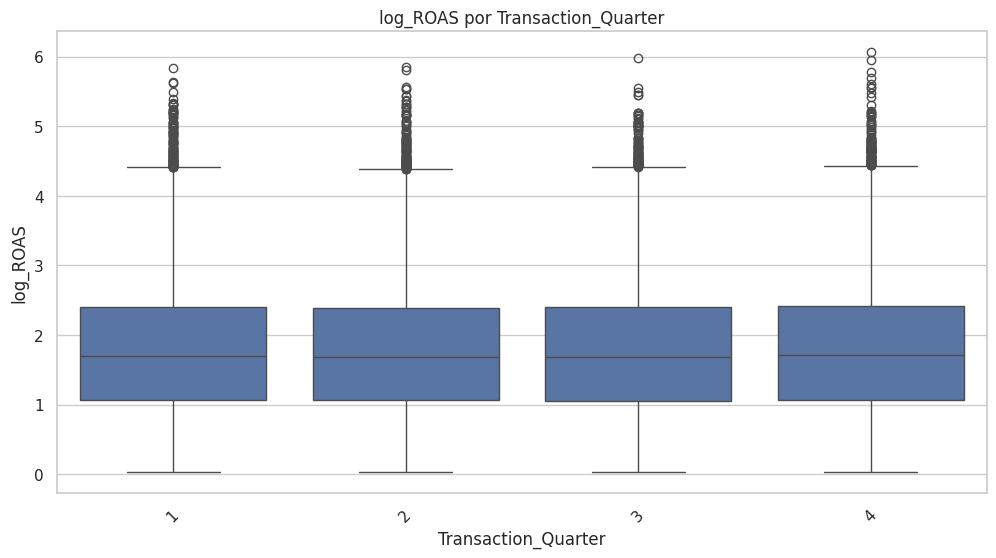

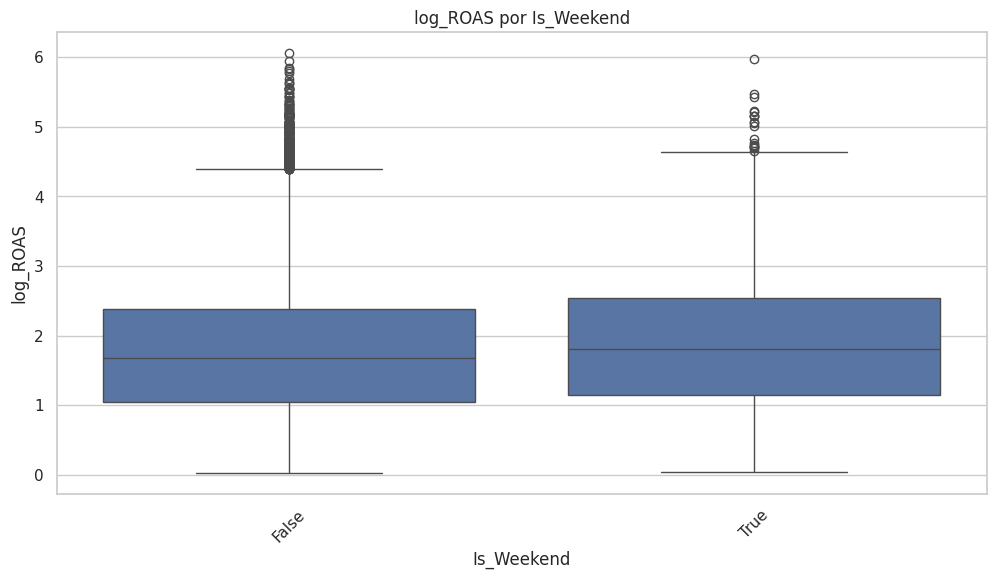

In [465]:
# Numerical scatter vs log_ROAS
for col in num_cols:
    plt.figure()
    sns.scatterplot(x=df[col], y=df['log_ROAS'])
    plt.title(f'{col} vs log_ROAS')
    plt.show()

# Categorical boxplots vs log_ROAS
for col in cat_cols:
    plt.figure()
    sns.boxplot(x=df[col], y=df['log_ROAS'])
    plt.title(f'log_ROAS por {col}')
    plt.xticks(rotation=45)
    plt.show()

### For Clasification

In [466]:
# View the average of numerical variables according to High_Spender
df.groupby("High_Margin")[num_cols].mean().T.sort_values(by=1, ascending=False)

High_Margin                   0           1
Impressions          275.884912  275.105062
Units_Sold           132.968725   80.471326
Clicks                22.320199   22.158128
log_Ad_Spend           4.526714    4.529930
Ad_CPC                 1.118454    1.112057
CTR_log_Clicks         0.321203    0.323475
Click_Efficiency       0.300661    0.297635
Discount_Applied       0.142143    0.119988
Ad_CTR                 0.111270    0.112314
log_Conversion_Rate    0.096836    0.096475
Weekend_Discount       0.003165    0.004050

#### Mann-Whitney U Test

In [467]:
print("Mann-Whitney U Test (High_Margin vs numeric):\n")
for col in num_cols:
    group0 = df[df["High_Margin"] == 0][col]
    group1 = df[df["High_Margin"] == 1][col]
    stat, p = mannwhitneyu(group0, group1, alternative="two-sided")
    print(f"{col:25s} p = {p:.4f}")

Mann-Whitney U Test (High_Margin vs numeric):

Units_Sold                p = 0.0000
Discount_Applied          p = 0.0000
Clicks                    p = 0.3984
Impressions               p = 0.6566
Ad_CTR                    p = 0.1294
Ad_CPC                    p = 0.3664
log_Ad_Spend              p = 0.4911
log_Conversion_Rate       p = 0.8243
CTR_log_Clicks            p = 0.3577
Weekend_Discount          p = 0.0000
Click_Efficiency          p = 0.2706


#### Chi-Square Test

In [ ]:
# Coding categorical variables to apply chi2
df_encoded = df[cat_cols + ["High_Margin"]].copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Calculate chi-square
chi_vals, p_vals = chi2(df_encoded[cat_cols], df_encoded["High_Margin"])

# Show results
print("\nChi-Square Test (High_Margin vs categorical):\n")
for col, p in zip(cat_cols, p_vals):
    print(f"{col:25s} p = {p:.4f}")

#### Variables vs High_Spender

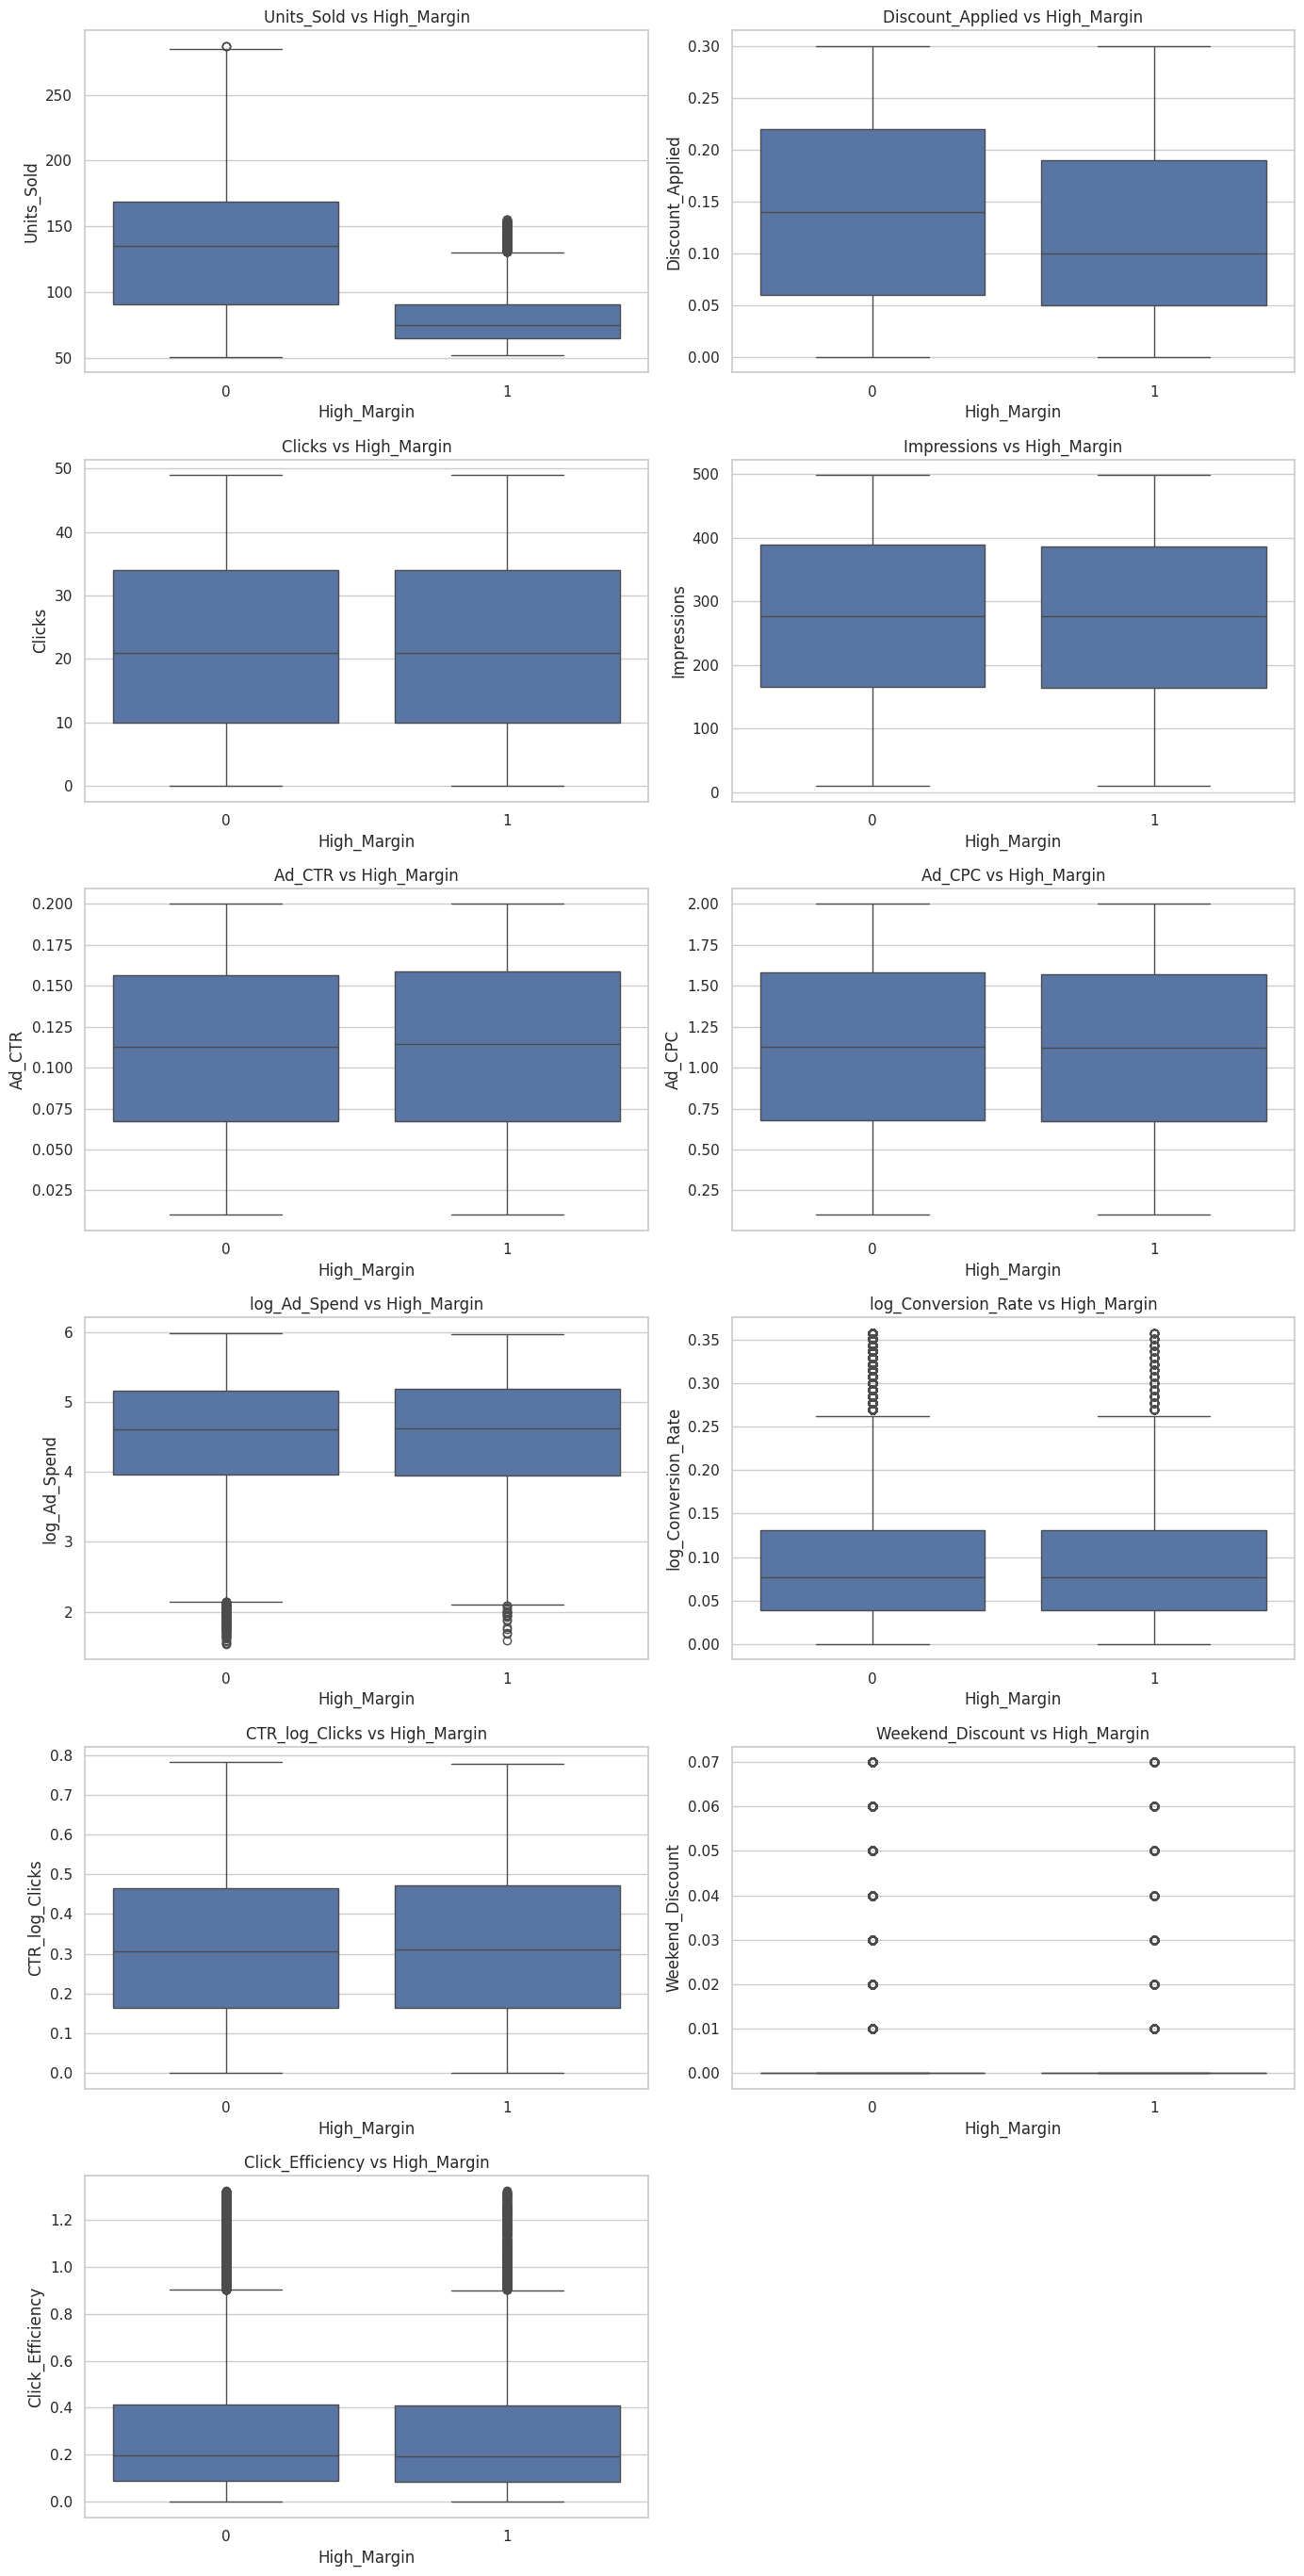

In [468]:
# Display of boxplots for all numeric variables with respect to High_Margin
plt.figure(figsize=(14, len(num_cols)*2.5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(math.ceil(len(num_cols)/2), 2, i)
    sns.boxplot(x='High_Margin', y=col, data=df)
    plt.title(f"{col} vs High_Margin")
    plt.tight_layout()
plt.show()

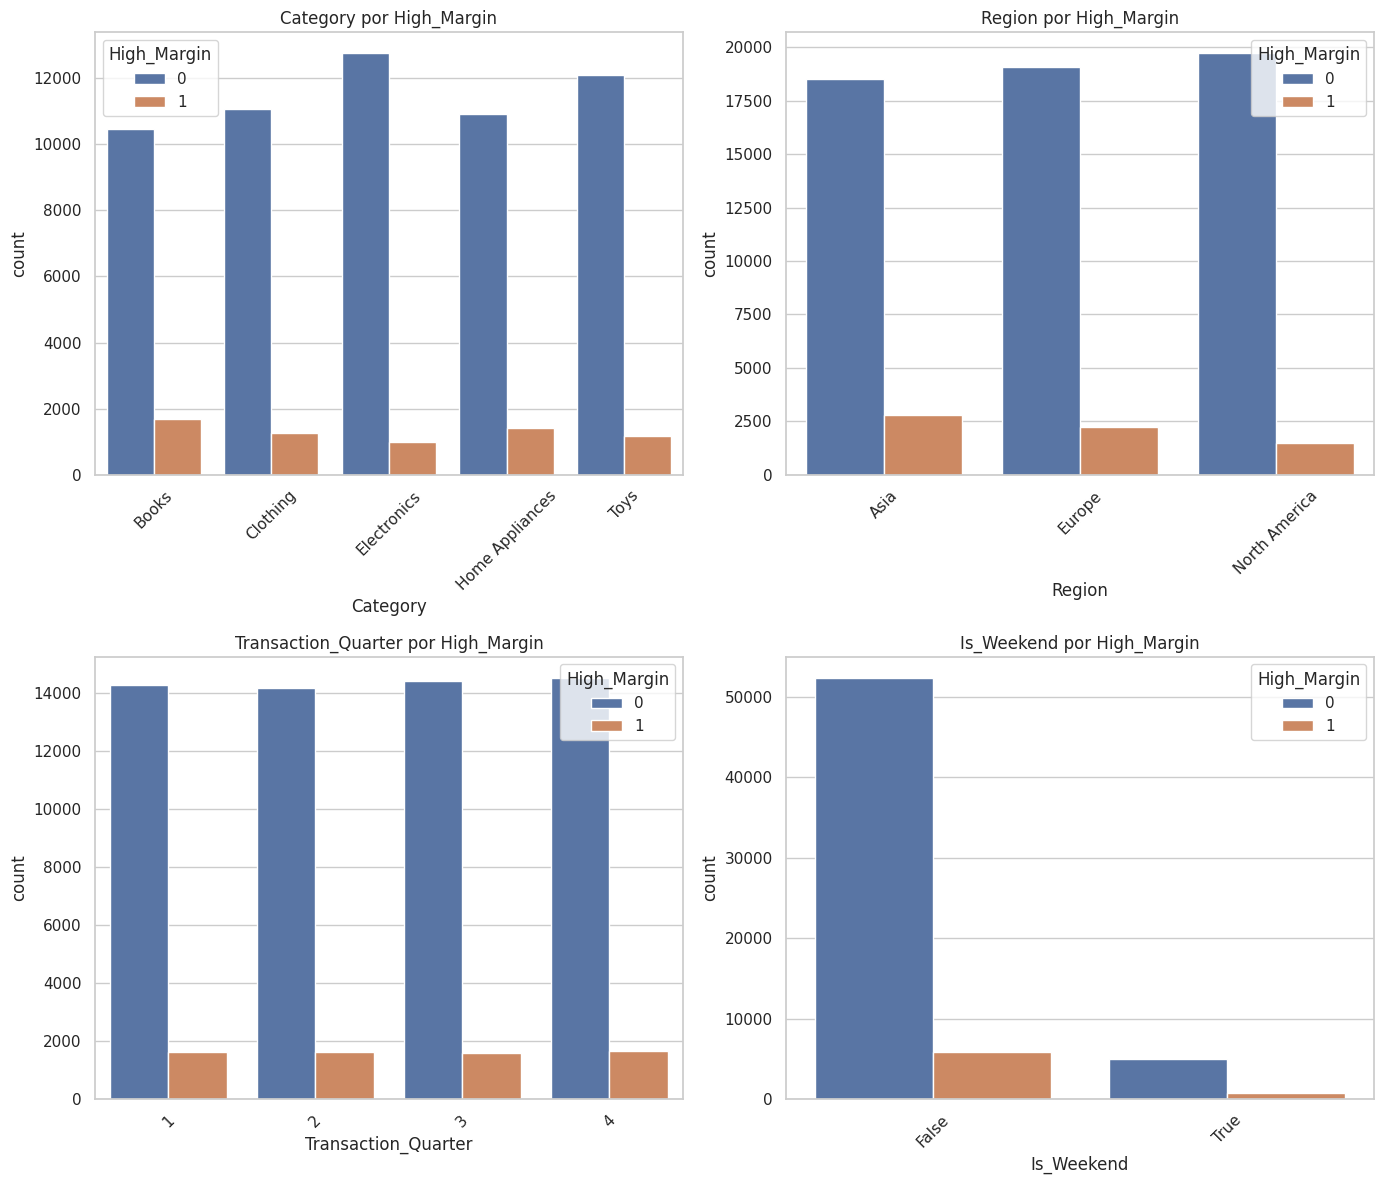

In [469]:
# Display of countplots for all categorical variables with respect to High_Margin
plt.figure(figsize=(14, len(cat_cols)*3))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(math.ceil(len(cat_cols)/2), 2, i)
    sns.countplot(x=col, hue='High_Margin', data=df)
    plt.title(f"{col} por High_Margin")
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

## Collinearity Reduction

The VIF (Variance Inflation Factor) is used to detect multicollinearity between independent variables in a regression model. High collinearity means that one variable can be predicted linearly from the others, which can distort the results of the model and make it less interpretable.

VIF interpretation > 10: High collinearity, may cause problems. It is recommended to eliminate or transform the variable.

VIF between 5 and 10: Keep an eye on it.

VIF < 5: Acceptable collinearity.



In [470]:
# target = 'log_Revenue'
# predictors = [col for col in num_cols if col != target]

# Make sure there are no nulls
X = df[num_cols].dropna()

# Add constant for VIF calculation
X_const = add_constant(X)

# Calculate VIF for each column
vif_data = pd.Series(
    [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
    index=X_const.columns
)

# Display the results excluding the constant
vif_data = vif_data.drop('const')
print("vif_data - detect collinearity:\n")
print(vif_data.sort_values(ascending=False))

vif_data - detect collinearity:

log_Ad_Spend           13.953057
Ad_CTR                 13.353061
CTR_log_Clicks         10.147205
Clicks                  7.098088
Ad_CPC                  5.785380
Click_Efficiency        4.381099
log_Conversion_Rate     4.337548
Impressions             2.819819
Weekend_Discount        1.078123
Discount_Applied        1.078097
Units_Sold              1.000141
dtype: float64


Eliminamos log_Ad_Spend ya que Ad_CPC aporta redundancia numérica por el simple hcho de la construcción matemática entre ellas (Ad_CPC = Ad_Spend / Clicks), y generan colinealidad artificial.

## Feature Selection

In [471]:
cat_cols

['Category', 'Region', 'Transaction_Quarter', 'Is_Weekend']

In [472]:
df = df.drop(columns=['log_Ad_Spend'])

# Final list for numerical variables
num_cols_final = [col for col in num_cols if col != 'log_Ad_Spend']

# Eliminate categoricals and transform
cat_cols_final = [col for col in cat_cols]

In [473]:
print(num_cols_final)
print(cat_cols_final)

['Units_Sold', 'Discount_Applied', 'Clicks', 'Impressions', 'Ad_CTR', 'Ad_CPC', 'log_Conversion_Rate', 'CTR_log_Clicks', 'Weekend_Discount', 'Click_Efficiency']
['Category', 'Region', 'Transaction_Quarter', 'Is_Weekend']


In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63869 entries, 0 to 63868
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Units_Sold           63869 non-null  int16   
 1   Discount_Applied     63869 non-null  float32 
 2   Clicks               63869 non-null  int16   
 3   Impressions          63869 non-null  int32   
 4   Category             63869 non-null  category
 5   Region               63869 non-null  category
 6   Ad_CTR               63869 non-null  float32 
 7   Ad_CPC               63869 non-null  float32 
 8   log_ROAS             63869 non-null  float32 
 9   High_Margin          63869 non-null  uint8   
 10  log_Conversion_Rate  63869 non-null  float32 
 11  Transaction_Quarter  63869 non-null  category
 12  Is_Weekend           63869 non-null  category
 13  Weekend_Discount     63869 non-null  float32 
 14  CTR_log_Clicks       63869 non-null  float32 
 15  Click_Efficiency   

# ML Models

## Data Preparation

In [475]:
# ──────────────────────────────────────────────────────────────
#  DIAGNÓSTICO RÁPIDO: Dummy vs. XGBoost crudo
# ──────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Asegura que las columnas categóricas sean dtype 'category'
cat_cols = ["Category", "Region", "Transaction_Quarter", "Is_Weekend"]
for col in cat_cols:
    df[col] = df[col].astype("category")

# 1️⃣ Split simple (sin preprocesado)
X_raw = df.drop(columns=["log_ROAS", "High_Margin"])
y_raw = df["log_ROAS"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# 2️⃣ Baseline “media”
dum = DummyRegressor(strategy="mean").fit(X_tr, y_tr)
rmse_dummy = np.sqrt(mean_squared_error(y_te, dum.predict(X_te)))
print("RMSE Dummy:", round(rmse_dummy, 3))

# 3️⃣ XGBoost crudo con categorías nativas
xgb_raw = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=400,
    enable_categorical=True,
    random_state=42,
)
xgb_raw.fit(X_tr, y_tr)
rmse_xgb = np.sqrt(mean_squared_error(y_te, xgb_raw.predict(X_te)))
print("RMSE XGBoost crudo:", round(rmse_xgb, 3))


RMSE Dummy: 0.954
RMSE XGBoost crudo: 0.725


In [476]:
# 🔸 1. Targets y separación X / y

target_reg = "log_ROAS"
target_clf = "High_Margin"

X = df.drop(columns=[target_reg, target_clf])
y_reg = df[target_reg]
y_clf = df[target_clf]

# 🔸 2. Columnas numéricas y categóricas definitivas
numeric_features = num_cols_final
categorical_features = cat_cols_final

# 🔸 3. Transformadores
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

numeric_transformer = Pipeline([
    ("yeojohnson", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 🔸 4. Helper para envolver cualquier estimador de regresión en un TTR

def make_reg_pipeline(base_estimator):
    """Devuelve un Pipeline con preprocesador + TransformedTargetRegressor."""

    ttr = TransformedTargetRegressor(
        regressor=base_estimator,
        transformer=Pipeline(
            [
                ("yeo", PowerTransformer(method="yeo-johnson")),
                ("scaler", StandardScaler()),
            ]
        ),
    )

    return Pipeline([
        ("pre", preprocessor),
        ("model", ttr),
    ])

## Models and Hyperparameter Spaces

In [477]:
reg_models = {
    # "RandomForest": (
    #     make_reg_pipeline(RandomForestRegressor(random_state=42)),
    #     {
    #         "model__n_estimators": [200, 500],
    #         "model__max_depth": [None, 10, 30],
    #     },
    # ),
    # "GradientBoosting": (
    #     make_reg_pipeline(GradientBoostingRegressor(random_state=42)),
    #     {
    #         "model__n_estimators": [200, 500],
    #         "model__learning_rate": [0.05, 0.1],
    #         "model__max_depth": [2, 3],
    #     },
    # ),
    # "MLPRegressor": (
    #     make_reg_pipeline(MLPRegressor(max_iter=1000, random_state=42)),
    #     {
    #         "model__hidden_layer_sizes": [(128,), (128, 64)],
    #         "model__activation": ["relu", "tanh"],
    #         "model__alpha": [1e-4, 1e-3],
    #     },
    # ),
    "XGBoost": (
        make_reg_pipeline(
            XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                random_state=42,
            )
        ),
        {
            "model__regressor__n_estimators":    [300, 600],
            "model__regressor__learning_rate":   [0.05, 0.1],
            "model__regressor__max_depth":       [3, 6],
            "model__regressor__subsample":       [0.8, 1],
            "model__regressor__colsample_bytree": [0.8, 1],
        },
    ),
}

# --------------------------- CLASIFICACIÓN ---------------------------
clf_models = {
    # "RandomForest": (
    #     RandomForestClassifier(class_weight="balanced", random_state=42),
    #     {
    #         "model__n_estimators": [200, 500],
    #         "model__max_depth": [None, 10, 30],
    #     },
    # ),
    # "GradientBoosting": (
    #     GradientBoostingClassifier(random_state=42),
    #     {
    #         "model__n_estimators": [200, 500],
    #         "model__learning_rate": [0.05, 0.1],
    #         "model__max_depth": [2, 3],
    #     },
    # ),
    # "MLPClassifier": (
    #     MLPClassifier(max_iter=1000, random_state=42),
    #     {
    #         "model__hidden_layer_sizes": [(128,), (128, 64)],
    #         "model__activation": ["relu", "tanh"],
    #         "model__alpha": [1e-4, 1e-3],
    #     },
    # ),
    "XGBoost": (
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=42,
            scale_pos_weight=y_clf.value_counts()[0] / y_clf.value_counts()[1],
        ),
        {
            "model__n_estimators":  [300, 600],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth":     [3, 6],
            "model__subsample":     [0.8, 1],
            "model__colsample_bytree": [0.8, 1],
        },
    ),
}

## Train and Evaluate Functions

In [478]:
def train_and_evaluate_regression(X, y):
    """Trains, does hyperparameter search and evaluates regression models defined
    in `reg_models`. Returns a DataFrame with performance metrics sorted by
    ascending RMSE."""

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    summary = []
    for name, (estimator, params) in reg_models.items():
        pipe = Pipeline([("pre", preprocessor), ("model", estimator)])
        search = RandomizedSearchCV(
            estimator,
            params,
            n_iter=10,
            cv=kf,
            n_jobs=-1,
            random_state=42,
            scoring="neg_root_mean_squared_error",
        )
        search.fit(X_tr, y_tr)
        y_pred = search.predict(X_te)

        # ---------------- Metrics & Report ----------------
        rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        mae = mean_absolute_error(y_te, y_pred)
        r2 = r2_score(y_te, y_pred)

        summary.append(
            {
                "Model": name,
                "Best Params": search.best_params_,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
            }
        )

        # ---------------- Reporting ----------------
        print(f"\n{name} – Métricas de Regresión:")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE : {mae:.3f}")
        print(f"  R2  : {r2:.3f}")

    return pd.DataFrame(summary).sort_values("RMSE")


def train_and_evaluate_classification(X, y):
    """It trains, does hyperparameter search and evaluates the classification models
    defined in `clf_models`. Returns a DataFrame with performance metrics sorted by
    descending F1."""

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    summary = []
    for name, (estimator, params) in clf_models.items():
        pipe = Pipeline([("pre", preprocessor), ("model", estimator)])
        search = RandomizedSearchCV(
            pipe,
            params,
            n_iter=10,
            cv=skf,
            n_jobs=-1,
            random_state=42,
            scoring="f1",
        )
        search.fit(X_tr, y_tr)
        y_pred = search.predict(X_te)

        # ---------------- Metrics & Report ----------------
        acc = accuracy_score(y_te, y_pred)
        prec = precision_score(y_te, y_pred)
        rec = recall_score(y_te, y_pred)
        f1 = f1_score(y_te, y_pred)
        cm = confusion_matrix(y_te, y_pred)

        summary.append(
            {
                "Model": name,
                "Best Params": search.best_params_,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
            }
        )

        # ---------------- Reporting ----------------
        print(f"\n{name} – Classification Report:")
        print(classification_report(y_te, y_pred, digits=3))

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Matriz de Confusión – {name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

    return pd.DataFrame(summary).sort_values("F1", ascending=False)

## ML Models Ejecution


XGBoost – Métricas de Regresión:
  RMSE: 0.689
  MAE : 0.565
  R2  : 0.477


Model                                        Best Params      RMSE  \
0  XGBoost  {'model__regressor__subsample': 0.8, 'model__r...  0.689462   

        MAE        R2  
0  0.565479  0.477452


XGBoost – Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.681     0.802     11466
           1      0.233     0.849     0.366      1308

    accuracy                          0.698     12774
   macro avg      0.604     0.765     0.584     12774
weighted avg      0.899     0.698     0.758     12774



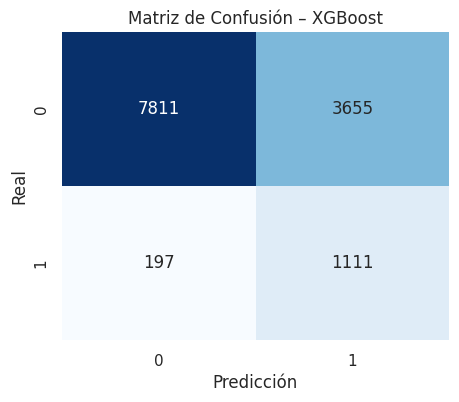

Model                                        Best Params  Accuracy  \
0  XGBoost  {'model__subsample': 1, 'model__n_estimators':...   0.69845   

   Precision    Recall        F1  
0    0.23311  0.849388  0.365822

In [479]:
df_reg_results = train_and_evaluate_regression(X, y_reg)
display(df_reg_results)

df_clf_results = train_and_evaluate_classification(X, y_clf)
display(df_clf_results)

## Best Model and Params

In [480]:
best_reg_row = df_reg_results.iloc[0]
best_clf_row = df_clf_results.iloc[0]

print("🏆  Mejor modelo REGRESIÓN:", best_reg_row["Model"])
print("    Parámetros óptimos:")
for k, v in best_reg_row["Best Params"].items():
    print(f"      {k}: {v}")

print("\n🏆  Mejor modelo CLASIFICACIÓN:", best_clf_row["Model"])
print("    Parámetros óptimos:")
for k, v in best_clf_row["Best Params"].items():
    print(f"      {k}: {v}")

🏆  Mejor modelo REGRESIÓN: XGBoost
    Parámetros óptimos:
      model__regressor__subsample: 0.8
      model__regressor__n_estimators: 300
      model__regressor__max_depth: 3
      model__regressor__learning_rate: 0.05
      model__regressor__colsample_bytree: 0.8

🏆  Mejor modelo CLASIFICACIÓN: XGBoost
    Parámetros óptimos:
      model__subsample: 1
      model__n_estimators: 300
      model__max_depth: 3
      model__learning_rate: 0.1
      model__colsample_bytree: 0.8
